## Image captioning project

### Data description - Flickr8k dataset 8000 images , 5 caption for each image 

In [1]:
import collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add


Using TensorFlow backend.


In [2]:
#read text captions
def readTextfile(path):
    with open(path) as f:
        
        captions = f.read() #readlines will also split caption that takes two lines of the files
    return captions


In [112]:
captions  = readTextfile("flickr8k/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt")
captions = captions.split('\n')[:-1]
#split each of the lines about \n and from each row take the last element very basic

In [113]:
captions[0]
#the number after #i.e 0 in this case represents caption no. so it is 0 for 1st caption, 1 for 2nd and so on

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .'

In [114]:
first,second = captions[0].split('\t') # first part is for image, second part is the caption of that image
print(first)
print(second)

1000268201_693b08cb0e.jpg#0
A child in a pink dress is climbing up a set of stairs in an entry way .


In [115]:
# Dictionary to Map each Image with the list of captions it has
descriptions = {}

for x in captions:
    first,second = x.split('\t')
    img_name = first.split(".")[0]
    
    #if the image id is already present or not
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []
    
    descriptions[img_name].append(second)

In [122]:
IMG_PATH = "flickr8k/Flickr_Data/Flickr_Data/Images/"
import cv2
img = cv2.imread(IMG_PATH+"1000268201_693b08cb0e.jpg")
cv2.imshow("img",img)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Data cleaning 

In [117]:
# we don't remove stopwords else our model will not know when to use common words like thhe, and etc.
# also don't feed stemmed words as the model will learn these words later
#we will convert our text to lowe case
# we will remove numbers, and punctuation marks

def cleantext(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence) #using regex to get rid of all non-alphabets and replacing them with space
    sentence = sentence.split()
    
    sentence  = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence

In [118]:
cleantext("A cat is sitting over the house # 64")

'cat is sitting over the house'

In [119]:
# Cleaning all Captions
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = cleantext(caption_list[i])

In [120]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [11]:
# Write the data to text file so use it for later purpose

with open("descriptions1.txt","w") as f:
    f.write(str(descriptions))

## Vocabulary 

In [3]:
# we will open our code from this point only
with open("descriptions1.txt",'r') as f:
    descriptions= f.read()
    
json_acceptable_string = descriptions.replace("'","\"")
descriptions = json.loads(json_acceptable_string)

In [4]:
#creating a set to store all the vocabulary from all the captions 
vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
     # basically  we iterate over all the images( keys) and then take their captions
        # then we split each caption about space (' ') and store each word in the vocab set
        # vocab will only have unique words
    
    
print("Vocab Size : %d"% len(vocab))

Vocab Size : 8424


In [5]:
# Total No of words across all the sentences
totalwords = []

for key in descriptions.keys():
    [totalwords.append(i) for des in descriptions[key] for i in des.split()] 
    #using list comprehension to append each word in totalwords
   
print("Total Words %d"%len(totalwords))

Total Words 373837


In [6]:
# Filter Words from the Vocab according to certain threshold frequncy 
# because we want to still shorten this vocab size and for that reason we take the words above a certain threshold frequency

# returns a dict subclass 
counter = collections.Counter(totalwords)
print(type(counter))

<class 'collections.Counter'>


In [7]:
freqcount = dict(counter)
print(len(freqcount.keys()))

8424


In [8]:
#sorting the dictionary in order of frequency count
sorted_freqcount = sorted(freqcount.items(),reverse = True,key = lambda x:x[1])

threshold = 10
print(type(sorted_freqcount))

<class 'list'>


In [9]:
sorted_freqcount = [x for x in sorted_freqcount if x[1]>threshold]

In [10]:
new_totalwords = [x[0] for x in sorted_freqcount] 
print(len(new_totalwords))

1845


In [11]:
print(new_totalwords)

['in', 'the', 'on', 'is', 'and', 'dog', 'with', 'man', 'of', 'two', 'white', 'black', 'boy', 'are', 'woman', 'girl', 'to', 'wearing', 'at', 'people', 'water', 'red', 'young', 'brown', 'an', 'his', 'blue', 'dogs', 'running', 'through', 'playing', 'while', 'shirt', 'down', 'standing', 'ball', 'little', 'grass', 'snow', 'child', 'person', 'jumping', 'over', 'three', 'front', 'sitting', 'holding', 'up', 'field', 'small', 'by', 'large', 'green', 'one', 'group', 'yellow', 'her', 'walking', 'children', 'men', 'into', 'air', 'beach', 'near', 'mouth', 'jumps', 'another', 'for', 'street', 'runs', 'its', 'from', 'riding', 'stands', 'as', 'bike', 'girls', 'outside', 'other', 'off', 'out', 'rock', 'next', 'play', 'orange', 'looking', 'pink', 'player', 'camera', 'their', 'pool', 'hat', 'jacket', 'boys', 'women', 'around', 'behind', 'some', 'background', 'dirt', 'toy', 'soccer', 'sits', 'dressed', 'has', 'wall', 'mountain', 'walks', 'crowd', 'along', 'plays', 'stand', 'looks', 'building', 'park', 'cl

In [12]:
with open('threshold vocab.txt','w') as f:
    f.write(str(new_totalwords))

In [13]:
# you can open this file as well directly and avoid the steps in the middle
with open('threshold vocab.txt','r') as f:
    new_totalwords= f.read()
json_acceptable_string2 = new_totalwords.replace("'","\"")
new_totalwords = json.loads(json_acceptable_string2)

## Preparing training and test data 

In [17]:
#we don't have a training and testing data separately 
#instead we have a traing and testing file which contais names of all files that should be used as training or testing
#also note that last entry is empty for both training and testing text file

In [14]:
train_filedata = readTextfile("flickr8k/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test_filedata = readTextfile("flickr8k/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt")

In [15]:
train = [row.split(".")[0] for row in train_filedata.split("\n")[:-1]] 
#splitting about . part because we don't want .jpg added 
#also we take all elements except last one that's why negative indexing 
test = [row.split(".")[0] for row in test_filedata.split("\n")[:-1]]

In [16]:
# Prepare Description for the Training Data
# Tweak - Add <s> and <e> token to our training data
#<s> is for start sequence and <e> is for end sequence 
#and these are necessary for the model to actually realize from where the sentence starts so as to start prediction 
#and where to end it

traindescriptions = {}

for imgid in train:
    traindescriptions[imgid] = []
    for cap in descriptions[imgid]:
        captoappend = "startseq "  + cap + " endseq"
        traindescriptions[imgid].append(captoappend)

In [17]:
traindescriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

### Transfer Learning
- Images --> Features
- Text ---> Features

## Step - 1 Image Feature Extraction

In [18]:
# we use pre trained resnet 50 model 
#notice that this has another column connected to which is there because resnet has skip connections 
#to avoid vanishing gradients
model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [19]:
#the second last layer takes input of (7,7,2048) and gives us an output of (2048)
#this happens because it takes into each 7*7 layer which contains info about a certain feature
#and the global average pooling layer takes each of those 7*7 input and replaces them with one value w
#whether that feature is there or not 

In [20]:

#taking the entire model except the final dense layer which flatten and gives the prediction
# we do this using the model API
modelnew = Model(model.input,model.layers[-2].output)

In [21]:
#function to pre process the images
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224)) #target size is a tuple of image height and image width
    img = image.img_to_array(img) #Converts a PIL Image instance to a Numpy array.
    img = np.expand_dims(img,axis=0) 
    #we will feed our model the images in batches, so input dim will be 4d i.e. (batch_size,224,224,3)
    #to do this we use the expand_dims function
    
    # Normalisation
    #resnet 50 has this feature which normalizes the image 
    img = preprocess_input(img)
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


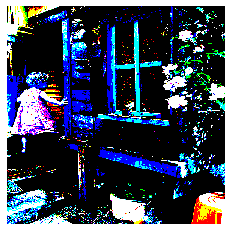

In [39]:
IMG_PATH = "flickr8k/Flickr_Data/Flickr_Data/Images/"
img = preprocess_img(IMG_PATH+"1000268201_693b08cb0e.jpg")
plt.imshow(img[0])
plt.axis("off")
plt.show()

In [22]:
def encode_image(img):
    
    #gives the preprocessed image this image is fed to the resnet model
    img = preprocess_img(img)
    
    #gives the output of the global pooling layer which for a single image will be 1X2048
    feature_vector = modelnew.predict(img)
    
    
    feature_vector = feature_vector.reshape((-1,)) #reshape to form a single row
#     print(feature_vector)
    return feature_vector

In [23]:
encode_image(IMG_PATH+"1000268201_693b08cb0e.jpg")

NameError: name 'IMG_PATH' is not defined

In [124]:
#to clock the time to do the job
start = time()

#a dictionary to map the encoding vector with the image 
encoding_train = {}
#image_id -->feature_vector extracted from Resnet Image

#taking the training data and enumerating it  
for ix,img_id in enumerate(train):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_train[img_id] = encode_image(img_path)
    
    # to check the progress
    if ix%100==0:
        print("Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken :",end_t-start)

TypeError: 'function' object is not iterable

In [43]:
# Store everything to the disk using pickle library
with open("saved/encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [156]:
#doing the same things with test set as well


start = time()

#a dictionary to map the encoding vector with the image 
encoding_test = {}
#image_id -->feature_vector extracted from Resnet Image

#taking the training data and enumerating it  
for ix,img_id in enumerate(test):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_test[img_id] = encode_image(img_path)
    
    # to check the progress
    if ix%100==0:
        print("Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken :",end_t-start)

Encoding in Progress Time step 0 


KeyboardInterrupt: 

In [108]:
with open("saved/encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

In [46]:

with open("saved/encoded_train_features2.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [47]:
with open("saved/encoded_test_features2.pkl","wb") as f:
    pickle.dump(encoding_test,f)

In [24]:
# open the encoding vectors from 
with open("saved/encoded_train_features.pkl","rb") as t:
    train_encode = pickle.load(t)

In [25]:
with open("saved/encoded_test_features.pkl","rb") as t:
    test_encode = pickle.load(t)

## Data pre-processing for captions

In [26]:


#we are going to reserve 0th index for padded space 
word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(new_totalwords):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

In [27]:
word_to_idx["dog"]

idx_to_word[1]
print(len(idx_to_word))

1845


In [28]:
# Also adding startseq and endseq to the dictionaries as well

idx_to_word[1846] = 'startseq'
word_to_idx['startseq'] = 1846

idx_to_word[1847] = 'endseq'
word_to_idx['endseq'] = 1847

vocab_size = len(word_to_idx) + 1
print("Vocab Size",vocab_size)

Vocab Size 1848


In [29]:
#finding maximum length of a caption 
max_len = 0 
for key in traindescriptions.keys():
    for cap in traindescriptions[key]:
        max_len = max(max_len,len(cap.split()))
        
print(max_len)

35


In [30]:
#we need to define our own data generators as the data generated is quite large
#and we need to feed the model our data in batches
#but the generator provided by keras is not good enough for this project

In [31]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2, y = [],[],[]
    
    n =0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            
            photo = encoding_train[key]
            for desc in desc_list:
                
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    #0 denote padding word
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorical([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield [[np.array(X1),np.array(X2)],np.array(y)]
                    X1,X2,y = [],[],[]
                    n = 0

## Word Embeddings

In [32]:
embedding = open('glove.6B.50d.txt',encoding='UTF-8')

In [33]:
#creating a dict from glove embeddings 
embedding_index = {}

for line in embedding:
    values = line.split()
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding

In [34]:
embedding.close()

In [35]:
embedding_index['mango'] #note that length is 50 or it is a 50 dimensional vector

array([ 0.26381 , -0.31832 , -1.0953  ,  1.3305  ,  0.24761 ,  0.045313,
       -0.39509 , -0.52107 , -0.016796,  0.33175 , -0.53252 ,  0.43263 ,
        1.2306  , -0.36963 ,  0.15989 , -0.433   , -0.29768 ,  0.768   ,
        0.71255 , -0.85675 , -0.076953, -1.0284  ,  0.9337  ,  0.24969 ,
       -0.13985 ,  1.0316  , -0.15809 ,  0.80512 ,  0.50535 , -0.50557 ,
        1.1237  , -0.45083 , -0.27552 ,  1.3537  ,  0.3553  ,  0.39403 ,
       -1.1213  ,  0.027925,  0.57582 , -0.63611 , -0.53506 , -0.080186,
       -0.78026 , -1.1595  ,  1.0318  ,  0.94337 ,  0.026387, -0.96839 ,
        0.54497 , -0.16479 ])

In [36]:
#this function will take all the words that are in our vocabulary and map it with the corresponding embedding vector
#this creates a matrix of dim(len of vocab,50)
def get_embeddingmatrix():
    #generating a matrix 
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
            
    return matrix

In [37]:
embedding_matrix = get_embeddingmatrix()
embedding_matrix.shape

(1848, 50)

In [38]:
embedding_matrix[1847] 
# as endseq is not there in glove embeddings, it is instead represented by a array of 50 zeroes

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Creating model archiitecture

In [61]:
#notice that there are two separate input layers created, one for the image and one for the captions
#they will be passed together in the input array

In [62]:
#creating the input layer
input_img_features = Input(shape=(2048,))

inp_img1 = Dropout(0.3)(input_img_features) #adding dropout layer for preventing overfitting

inp_img2 = Dense(256,activation='relu')(inp_img1) #this method says that input of inp_img2 will be 

In [63]:
# Captions as Input
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions) 
#this layer is added before lstm layer
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2) #lstm layer with 256 cells

In [64]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

# Combined Model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [65]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 35, 50)       92400       input_7[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 2048)         0           input_6[0][0]                    
____________________________________________________________________________________________

In [66]:
#make sure that the embedding layer we got, 
#we set its weights beforehand and we also set it as untrainable 
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [67]:
model.compile(loss='categorical_crossentropy',optimizer="adam")

## Model training

In [68]:
epochs = 20
batch_size = 3
steps = len(traindescriptions)//batch_size #they should be equal to number of 
print(steps)

2000


In [69]:
for i in range(epochs):
    generator = data_generator(traindescriptions,train_encode,word_to_idx,max_len,batch_size)
    #keras has fit generator function which gives us 
    model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
    model.save('./model_weights/model_'+str(i)+'.h5')

Epoch 1/1
2000/2000 [==============================] - 793s 396ms/step - loss: 4.2942
Epoch 1/1
2000/2000 [==============================] - 801s 400ms/step - loss: 3.5779
Epoch 1/1
2000/2000 [==============================] - 797s 399ms/step - loss: 3.3229
Epoch 1/1
2000/2000 [==============================] - 799s 400ms/step - loss: 3.1673
Epoch 1/1
2000/2000 [==============================] - 810s 405ms/step - loss: 3.0541
Epoch 1/1
2000/2000 [==============================] - 798s 399ms/step - loss: 2.9714
Epoch 1/1
2000/2000 [==============================] - 813s 407ms/step - loss: 2.9039
Epoch 1/1
2000/2000 [==============================] - 814s 407ms/step - loss: 2.8463
Epoch 1/1
2000/2000 [==============================] - 796s 398ms/step - loss: 2.7997
Epoch 1/1
2000/2000 [==============================] - 798s 399ms/step - loss: 2.7604
Epoch 1/1
2000/2000 [==============================] - 805s 402ms/step - loss: 2.7272
Epoch 1/1
2000/2000 [==============================] -

KeyboardInterrupt: 

In [71]:
model = load_model('./model_weights/model_18.h5')

In [72]:

def predict_caption(photo):
    
    in_text = "startseq" #start the sentence with startseq
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx] #
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post') 
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #Word with max prob always - Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1] # removing startseq and endseq and getting each word
    final_caption = ' '.join(final_caption)
    return final_caption





In [74]:
IMG_PATH = "flickr8k/Flickr_Data/Flickr_Data/Images/"

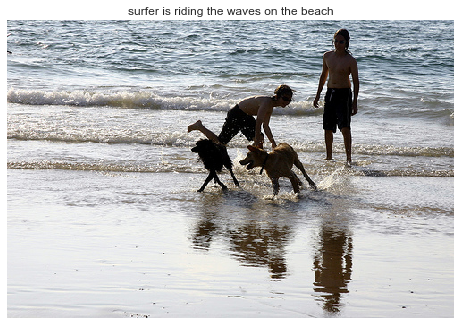

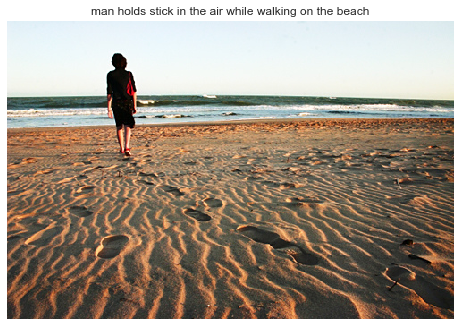

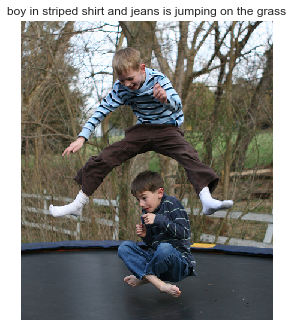

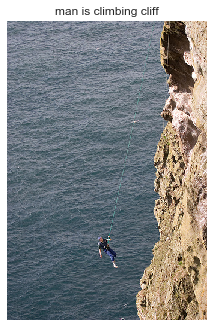

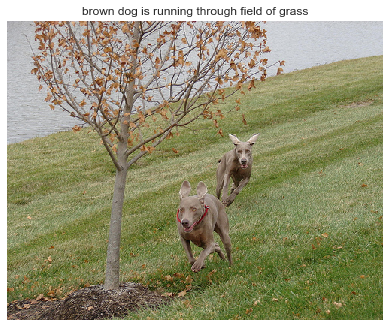

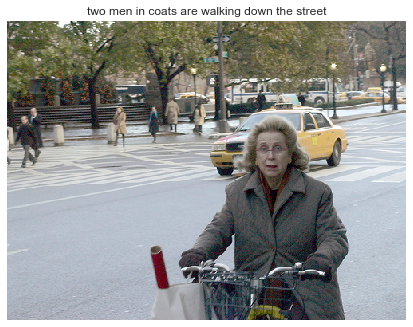

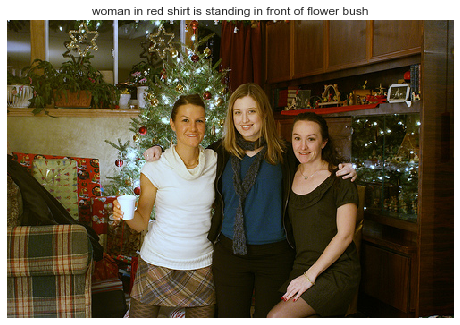

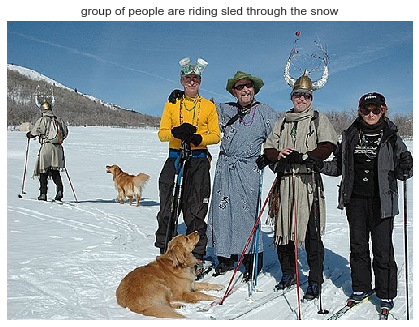

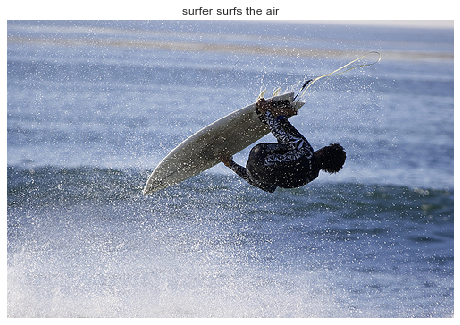

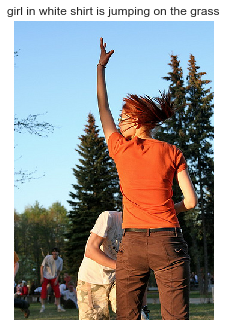

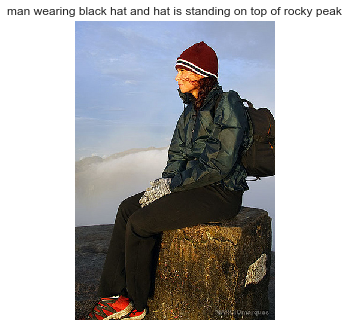

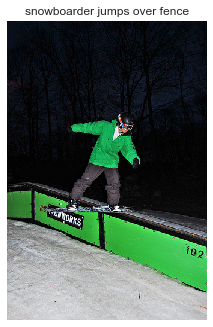

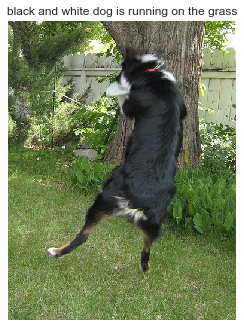

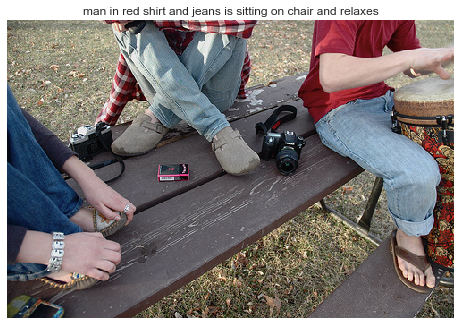

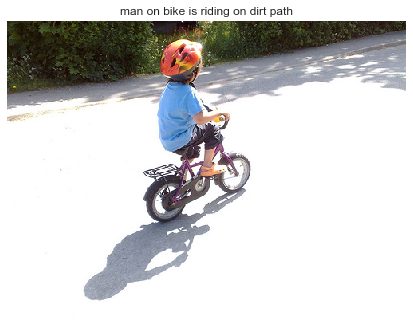

In [77]:
# Pick Some Random Images and See Results
plt.style.use("seaborn")
for i in range(15):
    idx = np.random.randint(0,1000) # out of the 1000 test images we randomly select some images
    all_img_names = list(test_encode.keys())
    img_name = all_img_names[idx] #image names of the images we selected 
    photo_2048 = test_encode[img_name].reshape((1,2048)) #reshape the flattened array of dimension (2048,)
    
    i = plt.imread(IMG_PATH+img_name+".jpg")
    
    caption = predict_caption(photo_2048)
    #print(caption)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()